The main goal of this exercice is to compare different classification methods, applied to the leaf images of kaggle datatset (https://www.kaggle.com/c/leaf-classification/data)

I will do it step by step : first the preprocessing, secondly classify with KNN method, then with multiclass SVM, and finally compare the performances of the different models to select the better one.

# 1. Introduction 

Let us fist import, describe, and preprocess the data :

In [14]:
data_path = "~/Documents/openclassroom/Fomation_ingenieur_ML/data/"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## sklearn module : 
from sklearn import model_selection 
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC

### 1. Opening file and Descriptive Analysis:

In [35]:
df = pd.read_csv(data_path+"Dataset_feuilles_1.csv")
## DROP MISSING VALUES : 
print("there are "+ str(df.isna().sum().sum()) + " missing values, we dropped them." )
df = df.dropna(axis = 0) 
## FIRST LOOK AT THE DATA :
print("n = "+ str(df.shape[0]) + " and p = " + str(df.shape[1]) ) 
df.head()

there are 0 missing values, we dropped them.
n = 990 and p = 194


,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


To sum up the first information : 
* $y$ is the vector of species, the categrical class to be learnd. There are 99 different species, and 990 individuals in our training set. 

* $X$ is the big matrice, that we can decompose as 
    $$X = \begin{pmatrix} \begin{pmatrix} margin  \\n \times 64  \end{pmatrix} ,
                         & \begin{pmatrix} shape  \\n \times 64  \end{pmatrix} ,
                         & \begin{pmatrix} texture  \\n \times 64  \end{pmatrix}
          \end{pmatrix}$$  
    And each submatrice is numerical. 
    It would be appropriate to first standardize with respect to this stucture (in case there is a big drift between data).

### Classification variable $y$ : 
The categorical $y$ vector is str categories, let's transform it into a number class. The information of translation is save in the "y_str" pandas.DataFrame. 

In [330]:
y_str = df.species
## y values encoder :
from sklearn.preprocessing import LabelEncoder 
my_label_encoder = LabelEncoder()
my_label_encoder.fit(y_str)

y = pd.Series(my_label_encoder.transform(y_str), dtype="category", name="class")
y_str = pd.concat((y_str,pd.Series(y)), axis=1)
# y_str.columns=("species","class")
# y_str.dtype = "category"

print("There are "+str(len(np.unique(y)))+ " different species to classify.")
y_str.head()

There are 99 different species to classify.


,species,class
0,Acer_Opalus,3
1,Pterocarya_Stenoptera,49
2,Quercus_Hartwissiana,65
3,Tilia_Tomentosa,94
4,Quercus_Variabilis,84


### Description Variables $X$ : 

In [331]:
X = df.drop(["id", "species"], axis = 1)
X.describe(include ="all")

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,0.018639,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,0.016071,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,0.005859,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,0.015625,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,0.027344,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,0.097656,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


Let's look a statistical description of the values (of flattened matrices) for "margin", "reshape", and "texture" : 

,margin,shape,texture
count,63360.000000,63360.000000,63360.000000
mean,0.015625,0.000607,0.015625
std,0.021334,0.000302,0.031434
min,0.000000,0.000022,0.000000
25%,0.001953,0.000398,0.000000
50%,0.007812,0.000558,0.003906
75%,0.021484,0.000748,0.018555
max,0.388670,0.003007,0.853520


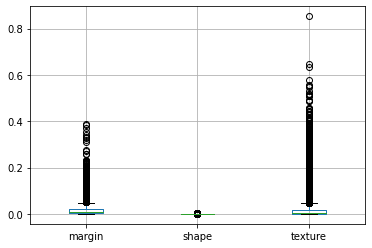

In [397]:
X_decomposed = pd.DataFrame( [X.values.reshape(n,3,64)[:,0,:].flatten(),
                               X.values.reshape(n,3,64)[:,1,:].flatten(),
                               X.values.reshape(n,3,64)[:,2,:].flatten()],
                             index = ["margin","shape","texture"]).T
X_decomposed.boxplot()
X_decomposed.describe()

In this data structure, there is a big drift between the "shape" variable and the others "margin" and "texture" ($\approx \times 100$)

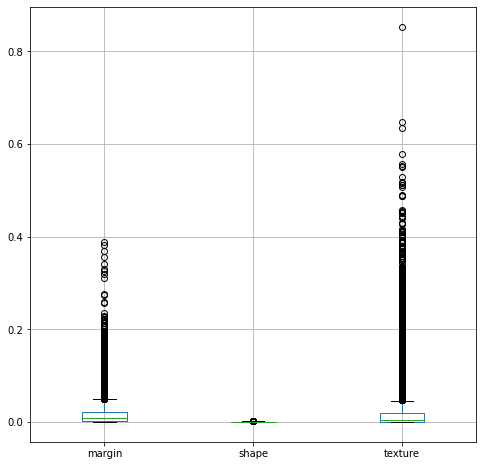

In [333]:
plt.figure(figsize = (8,8))
plt.show()

Let's see if there are some outliers leaves (individuals) by projecting the X data in a 2-d space, with PCA :

Explained variance ratio : [0.36731316 0.13511645]


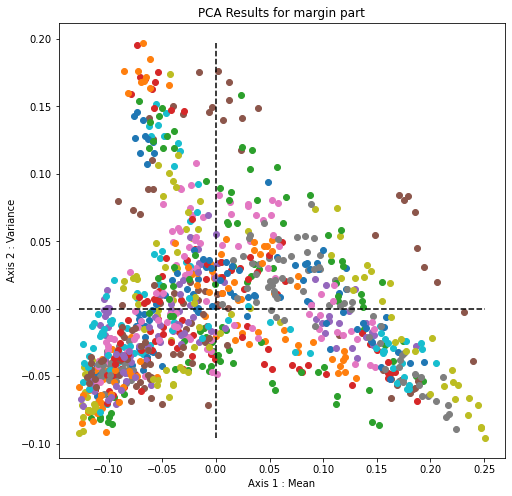

Explained variance ratio : [0.73089031 0.18320153]


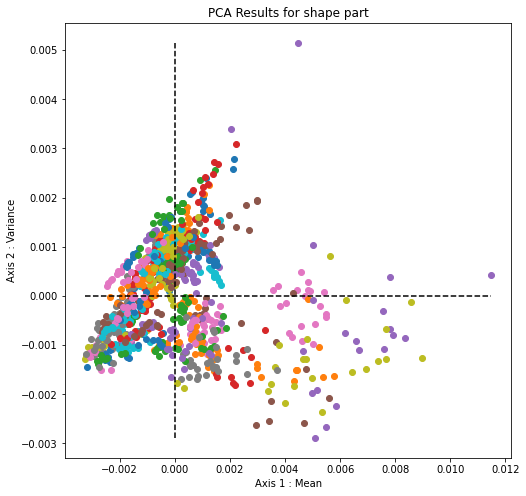

Explained variance ratio : [0.18929111 0.12025495]


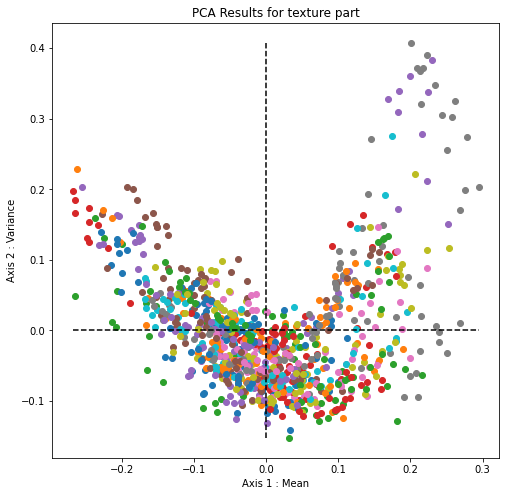

Explained variance ratio : [0.14980004 0.101889  ]


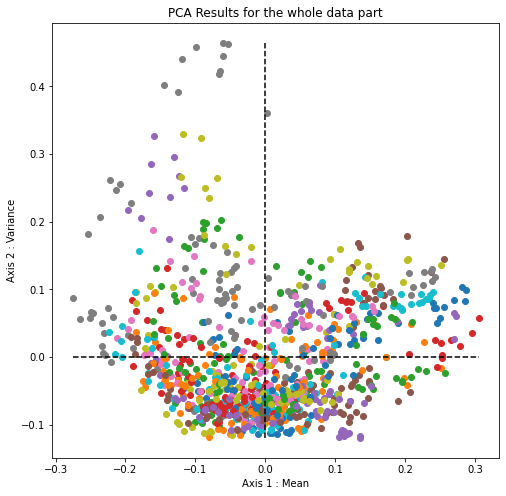

In [375]:
from sklearn.decomposition import PCA
subX = X.values.reshape(n,3,64)[:,0,:]

# from sklearn.preprocessing import StandardScaler
# my_std = preprocessing.StandardScaler()
# my_std.fit(subX)
# subX = my_std.transform(subX)

def plot_pca_submatrix(subX, sub_title=""):
    pca = PCA(n_components=2)
    pca.fit(subX)
    print("Explained variance ratio :", str(pca.explained_variance_ratio_))

    Xpca = pd.concat((y,pd.DataFrame(pca.transform(subX),columns=["ax1","ax2"])),axis=1)
    plt.figure(figsize = (8,8))
    for leaf_class in np.unique(Xpca["class"]):
        tmp = Xpca[Xpca["class"] ==leaf_class]
        plt.scatter(tmp['ax1'],tmp['ax2'], marker="o")
    plt.plot([Xpca["ax1"].min(),Xpca["ax1"].max()], [0,0], linestyle="--", color='black')
    plt.plot([0,0], [Xpca["ax2"].min(),Xpca["ax2"].max()], linestyle="--", color='black')
    plt.Circle([0,0],1,linestyle="--")
    if sub_title == "" :
        plt.title("PCA Results") 
    else :
        plt.title("PCA Results for " + sub_title + " part")
    plt.xlabel("Axis 1 : Mean")
    plt.ylabel("Axis 2 : Variance")
    plt.show()

plot_pca_submatrix(X.values.reshape(n,3,64)[:,0,:],"margin")
plot_pca_submatrix(X.values.reshape(n,3,64)[:,1,:],"shape")
plot_pca_submatrix(X.values.reshape(n,3,64)[:,2,:],"texture")
plot_pca_submatrix(X.values, "the whole data")

It doesn't seem to have some outliers in the data. Let's now standardize each sub-matrix : 

In [395]:
from sklearn.preprocessing import StandardScaler
my_std = preprocessing.StandardScaler()

## STANDARDIZATION ON EACH SUB-MATRIX :
X_std = X.copy()
for k in [0,1,2]:
    subX = X.values.reshape(n,3,64)[:,k,:]
    my_std.fit(subX)
    subX = my_std.transform(subX)
    X_std.iloc[:,k*64:(k+1)*64] = my_std.transform(subX)
    
## AND STANDARDIZATION OF THE GLOBAL X : 
my_std.fit(X_std)
X_std.iloc[:,:] = my_std.transform(X_std)

,margin,shape,texture
count,6.336000e+04,6.336000e+04,6.336000e+04
mean,-7.850062e-19,-5.382900e-18,2.971809e-18
std,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.520978e+00,-2.565864e+00,-1.162301e+00
25%,-6.336042e-01,-6.508590e-01,-5.554379e-01
50%,-3.159489e-01,-1.519546e-01,-3.405698e-01
75%,3.682714e-01,4.617857e-01,1.546105e-01
max,1.475771e+01,7.094418e+00,1.317951e+01


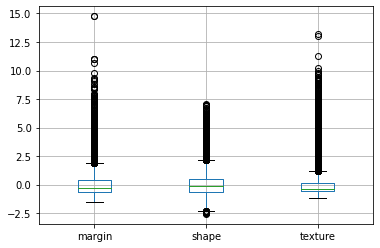

In [396]:
X_decomposed = pd.DataFrame( [X_std.values.reshape(n,3,64)[:,0,:].flatten(),
                               X_std.values.reshape(n,3,64)[:,1,:].flatten(),
                               X_std.values.reshape(n,3,64)[:,2,:].flatten()],
                             index = ["margin","shape","texture"]).T
X_decomposed.boxplot()
X_decomposed.describe()

### Sampling : split train and test data :
Now, let's extract our training and testing samples.

In [401]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size = 0.8)

# 2. k Nearest Neighbors Classification (KNN) : 

In [436]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# knn_param_grid = {"n_neighbors" : np.arange(1,16), "metric" : ["minkowski", "euclidean","manhattan"], "weights" : ["uniform", "distance"]  }
knn_param_grid = {"n_neighbors" : np.arange(1,10), "metric" : ["minkowski", "euclidean","manhattan"], "weights" : ["distance"]  }

CV_knn = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)
CV_knn.fit(X_train, y_train)
knn_kwargs = CV_knn.best_params_

print(knn_kwargs)

{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}


In [ ]:
y_scores = CV_knn.cv_results_["mean_test_score"]

lr_FPrate, lr_TPrate, lr_thresholds = roc_curve(y_test, lr_y_proba)
lr_roc_auc = auc(lr_FPrate, lr_TPrate)
print(lr_roc_auc)

plt.figure(figsize = (7,7))
plt.plot(lr_FPrate,lr_TPrate, color="red", label = "AUC = %0.3f for Logistic Regression"%lr_roc_auc)
## LEGEND AND AXIS : 
plt.legend(loc="lower right")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve")
plt.plot([0,1],[0,1], linestyle = '--') # random classif results
plt.plot()

In [438]:
CV_knn.cv_results_["mean_test_score"]
sort_index = np.argsort(CV_knn.cv_results_["rank_test_score"])

for k in sort_index :
    print(CV_knn.cv_results_["rank_test_score"][k])
    my_dict = CV_knn.cv_results_["params"][k]
    print(my_dict['metric'], my_dict['n_neighbors'])

1
manhattan 3
1
manhattan 2
1
manhattan 1
4
manhattan 4
5
minkowski 4
5
euclidean 4
7
minkowski 1
7
minkowski 2
7
euclidean 1
7
euclidean 2
11
minkowski 3
11
euclidean 3
13
euclidean 5
13
minkowski 5
15
manhattan 6
16
manhattan 5
17
manhattan 7
18
manhattan 8
19
euclidean 6
19
minkowski 6
21
euclidean 8
21
minkowski 8
23
euclidean 7
23
minkowski 7
25
manhattan 9
26
euclidean 9
26
minkowski 9


In [427]:
sort_index[0]

60